In [35]:
# Importing packages and modules:
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm
import requests as req
import io
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm, ListedColormap

# Determinands:

In [2]:
# input determinands ids:
dtrs = input("Enter determinands ids (separated by space):").split()

Enter determinands ids (separated by space): 0111 0117 0118 9686 0180 0348


In [3]:
# Dictionaries mapping each determinand to its label and abbreviation:
dtrs_labels = {
    "0111": "NH4 (#0111)",
    "0116": "NOx (#0116)",
    "0117": "NO3 (#0117)",
    "0118": "NO2 (#0118)",
    "9686": "Total N (#9686)",
    "0348": "Total P (#0348)",
    "0180": "PO4 (#0180)"
}

dtrs_abbrev = {
    "0111": "NH4",
    "0116": "NOx",
    "0117": "NO3",
    "0118": "NO2",
    "9686": "TN",
    "0348": "TP",
    "0180": "PO4"
}

# Study Period:

In [4]:
# input start and end date of the study period:
start_date_str = input("Enter start date (YYYY-MM-DD):")
end_date_str = input("Enter end date (YYYY-MM-DD):")

# Converting dates from strings into datetime objects:
start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
start_yr = start_date.year
end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
end_yr = end_date.year

Enter start date (YYYY-MM-DD): 2000-01-01
Enter end date (YYYY-MM-DD): 2024-12-31


# WQ Sites:

In [5]:
sites = input("Enter site ids (separated by space):").split()

Enter site ids (separated by space): AN-26M31 TH-PTHR0107 AN-51M01 AN-53M14 AN-NENE640D AN-WEN250 TH-PWAE0010 NE-43500692


# Fetching WQ Data:

In [6]:
# Creating nested dictionaries to store determinand & sites data:
dtrs_dic = {}
for dtr_id in dtrs:
    dtrs_dic[dtr_id] = {}


# WQA API Base url: 
base_url = "https://environment.data.gov.uk/water-quality"
## Request are made through the 'Observations' endpoint (site by site for each dtr).


# Iterating through predefined determinands:
for dtr in tqdm(dtrs,
                desc = f"Fetching concentration data for {len(dtrs)} determinands"
               ):
    
    dtr_dic = {}
    dtr_label = dtrs_labels.get(dtr)

    ## Defining the query parameters & headers (data type):
    params = {
        "dateFrom": start_date_str, ## start and end date parameters must be in string format here
        "dateTo": end_date_str,
        "limit": 250,
        "complianceOnly": "false", 
        "determinand": dtr
    }
    
    headers = {
        "accept": "text/csv",
        "Accept-Crs": "http://www.opengis.net/def/crs/EPSG/0/27700",
        "CSV-Header": "present",
        "API-Version": "1"
    }


    ## Looping through sites:
    for site_id in tqdm(
        sites,
        desc = f"Fetching {dtr_label} data across {len(sites)} sites"
    ):

        # The new api has a limit of 250 observation per query (site data will be retrieved in chunks):
        all_site_chunks = []
        skip = 0

        while True:
            ### Update pagination parameter "skip":
            params["skip"] = skip

            ### Sending the API request (observations 'with point notation' endpoint):
            obs_endpoint = f"{base_url}/sampling-point/{site_id}/observation"
            resp = req.get(obs_endpoint, params = params, headers = headers)

            ### 1) if the request did not work:
            if resp.status_code != 200:
                print(f"⛔ Failed Request Error {resp.status_code} for {dtr_label} at {site_id}")
                break

            ### 2) if request works, adding the site data to the dictionary:
            try:
                csv_text = resp.text.strip()
                if not csv_text or csv_text.count('\n') <= 1: # check for sites with exactly 250 rows!
                    break
                    
                site_chunk = pd.read_csv(
                io.StringIO(resp.text),
                dtype = {"determinand.notation": "str"}, # determinand id has leading zeroes on WIMS
                parse_dates = ["phenomenonTime"]
                )

                if site_chunk.empty:
                    break

                #### Cleaning of datetime columns, adding separate date and time columns:
                site_chunk['date'] = site_chunk['phenomenonTime'].dt.date
                site_chunk['time'] = site_chunk['phenomenonTime'].dt.time
                site_chunk['date'] = pd.to_datetime(site_chunk['date'])

                #### Seperating the result column into qual & result_num column using regex:
                pattern = r'^(<)?\s*([0-9.]+)$'
                site_chunk[['qual', 'result_num']] = site_chunk['result'].astype(str).str.extract(pattern)
                site_chunk['result_num'] = site_chunk['result_num'].astype(float)

                all_site_chunks.append(site_chunk)

                if len(site_chunk) < 250:
                    break
                skip += 250

            ### 3) In case of parsing errors:
            except pd.errors.ParserError:
                print(f"⚠️ Parser Error for {dtr_label} at {site_id}")
                break

            ### 4) Empty data error (no data for that site/dtr): 
            except pd.errors.EmptyDataError:
                print(f"⚠️ Empty Data Error for {dtr_label} at {site_id}")
                break
                    
        ### Merging site data:
        if all_site_chunks:
            site_data = pd.concat(all_site_chunks, ignore_index=True)
            dtr_dic[site_id] = site_data
        
            
    ## Assigning the created dtr dictionary to the main dtr dic:
    dtrs_dic[dtr] = dtr_dic                

Fetching concentration data for 6 determinands:   0%|          | 0/6 [00:00<?, ?it/s]

Fetching NH4 (#0111) data across 8 sites:   0%|          | 0/8 [00:00<?, ?it/s]

Fetching NO3 (#0117) data across 8 sites:   0%|          | 0/8 [00:00<?, ?it/s]

⛔ Failed Request Error 204 for NO3 (#0117) at TH-PWAE0010


Fetching NO2 (#0118) data across 8 sites:   0%|          | 0/8 [00:00<?, ?it/s]

⛔ Failed Request Error 204 for NO2 (#0118) at TH-PWAE0010


Fetching Total N (#9686) data across 8 sites:   0%|          | 0/8 [00:00<?, ?it/s]

⛔ Failed Request Error 204 for Total N (#9686) at TH-PWAE0010
⛔ Failed Request Error 204 for Total N (#9686) at NE-43500692


Fetching PO4 (#0180) data across 8 sites:   0%|          | 0/8 [00:00<?, ?it/s]

Fetching Total P (#0348) data across 8 sites:   0%|          | 0/8 [00:00<?, ?it/s]

In [7]:
# Melting all the dictionaries into one dataframe:
all_records = []

for dtr_id, dtr_dict in dtrs_dic.items():
    for site_id, site_df in dtr_dict.items():
        if isinstance(site_df, pd.DataFrame) and not site_df.empty:
            site_df = site_df.copy()
            all_records.append(site_df)

wqa = pd.concat(all_records, ignore_index=True)

wqa

,id,samplingPoint.notation,samplingPoint.prefLabel,samplingPoint.easting,samplingPoint.northing,samplingPoint.region,samplingPoint.area,samplingPoint.subArea,samplingPoint.samplingPointStatus,samplingPoint.samplingPointType,...,samplingPurpose,sampleMaterialType,determinand.notation,determinand.prefLabel,result,unit,date,time,qual,result_num
0,http://environment.data.gov.uk/water-quality/s...,AN-26M31,HUNDRED FOOT RIVER EARITH RD.BR.,539315,274729,Anglian,ANGLIAN - CAMBS AND BEDFORDSHIRE,ELY TEAM SUB AREA,OPEN,FRESHWATER - RIVERS,...,PLANNED INVESTIGATION (LOCAL MONITORING),RIVER / RUNNING SURFACE WATER,0111,Ammoniacal Nitrogen as N,<0.03,MILLIGRAM PER LITRE,2000-02-29,12:25:00,<,0.030
1,http://environment.data.gov.uk/water-quality/s...,AN-26M31,HUNDRED FOOT RIVER EARITH RD.BR.,539315,274729,Anglian,ANGLIAN - CAMBS AND BEDFORDSHIRE,ELY TEAM SUB AREA,OPEN,FRESHWATER - RIVERS,...,ENVIRONMENTAL MONITORING STATUTORY (EU DIRECTI...,RIVER / RUNNING SURFACE WATER,0111,Ammoniacal Nitrogen as N,0.095,MILLIGRAM PER LITRE,2000-01-11,10:16:00,NaN,0.095
2,http://environment.data.gov.uk/water-quality/s...,AN-26M31,HUNDRED FOOT RIVER EARITH RD.BR.,539315,274729,Anglian,ANGLIAN - CAMBS AND BEDFORDSHIRE,ELY TEAM SUB AREA,OPEN,FRESHWATER - RIVERS,...,ENVIRONMENTAL MONITORING STATUTORY (EU DIRECTI...,RIVER / RUNNING SURFACE WATER,0111,Ammoniacal Nitrogen as N,0.126,MILLIGRAM PER LITRE,2000-03-02,14:30:00,NaN,0.126
3,http://environment.data.gov.uk/water-quality/s...,AN-26M31,HUNDRED FOOT RIVER EARITH RD.BR.,539315,274729,Anglian,ANGLIAN - CAMBS AND BEDFORDSHIRE,ELY TEAM SUB AREA,OPEN,FRESHWATER - RIVERS,...,PLANNED INVESTIGATION (LOCAL MONITORING),RIVER / RUNNING SURFACE WATER,0111,Ammoniacal Nitrogen as N,0.042,MILLIGRAM PER LITRE,2000-02-29,17:10:00,NaN,0.042
4,http://environment.data.gov.uk/water-quality/s...,AN-26M31,HUNDRED FOOT RIVER EARITH RD.BR.,539315,274729,Anglian,ANGLIAN - CAMBS AND BEDFORDSHIRE,ELY TEAM SUB AREA,OPEN,FRESHWATER - RIVERS,...,ENVIRONMENTAL MONITORING STATUTORY (EU DIRECTI...,RIVER / RUNNING SURFACE WATER,0111,Ammoniacal Nitrogen as N,0.046,MILLIGRAM PER LITRE,2000-05-10,12:00:00,NaN,0.046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18758,http://environment.data.gov.uk/water-quality/s...,NE-43500692,BIRTLEY STW FINAL EFFLUENT (TO LAMESLEY WETLAN...,425630,556730,NorthEast,NORTH EAST - NORTHUMBERLAND DURHAM AND TEES,NORTHUMBERLAND & TYNE,OPEN,SEWAGE DISCHARGES - FINAL/TREATED EFFLUENT - W...,...,COMPLIANCE AUDIT (PERMIT),FINAL SEWAGE EFFLUENT,0348,"Phosphorus, Total as P",2.73,MILLIGRAM PER LITRE,2008-10-28,13:10:00,NaN,2.730
18759,http://environment.data.gov.uk/water-quality/s...,NE-43500692,BIRTLEY STW FINAL EFFLUENT (TO LAMESLEY WETLAN...,425630,556730,NorthEast,NORTH EAST - NORTHUMBERLAND DURHAM AND TEES,NORTHUMBERLAND & TYNE,OPEN,SEWAGE DISCHARGES - FINAL/TREATED EFFLUENT - W...,...,COMPLIANCE AUDIT (PERMIT),FINAL SEWAGE EFFLUENT,0348,"Phosphorus, Total as P",2.65,MILLIGRAM PER LITRE,2008-11-14,10:45:00,NaN,2.650
18760,http://environment.data.gov.uk/water-quality/s...,NE-43500692,BIRTLEY STW FINAL EFFLUENT (TO LAMESLEY WETLAN...,425630,556730,NorthEast,NORTH EAST - NORTHUMBERLAND DURHAM AND TEES,NORTHUMBERLAND & TYNE,OPEN,SEWAGE DISCHARGES - FINAL/TREATED EFFLUENT - W...,...,COMPLIANCE AUDIT (PERMIT),FINAL SEWAGE EFFLUENT,0348,"Phosphorus, Total as P",2.7,MILLIGRAM PER LITRE,2008-12-11,10:15:00,NaN,2.700
18761,http://environment.data.gov.uk/water-quality/s...,NE-43500692,BIRTLEY STW FINAL EFFLUENT (TO LAMESLEY WETLAN...,425630,556730,NorthEast,NORTH EAST - NORTHUMBERLAND DURHAM AND TEES,NORTHUMBERLAND & TYNE,OPEN,SEWAGE DISCHARGES - FINAL/TREATED EFFLUENT - W...,...,COMPLIANCE AUDIT (PERMIT),FINAL SEWAGE EFFLUENT,0348,"Phosphorus, Total as P",3.2,MILLIGRAM PER LITRE,2009-01-28,11:43:00,NaN,3.200


# Annual Sampling Frequencies:

In [28]:
# Initialising a dictionary to store each determinand annual smaples:
sampling_freq = {}

# Each detrminand will have a dataframe that consists sites (rows) and years (columns):
study_years = pd.date_range(start = start_date, end = end_date, freq="YS").year

# Looping through determinands:
for dtr in dtrs:
    dtr_label = dtrs_labels.get(dtr)
    dtr_count = pd.DataFrame(0, index = sites, columns = study_years).astype(str)

    ## Looping through sites:
    for site in sites:
        if site in dtrs_dic[dtr]:
            site_df = dtrs_dic[dtr][site].copy()
        
        ### Checking for duplicates:
        n_dupes = site_df.duplicated(subset='phenomenonTime').sum()
        if n_dupes > 0:
            print(f"{dtr_label} at {site}: {n_dupes} duplicate dates")


        ### Counting annual samples per site:
        site_df['year'] = site_df['phenomenonTime'].dt.year
        annual_count = site_df.drop_duplicates(subset='phenomenonTime').groupby('year')['phenomenonTime'].count().to_dict()
        for yr, count in annual_count.items():
            dtr_count.at[site, yr] = count  ## site must be an index here
            dtr_count = dtr_count.astype("int") ## mapped from a dictionary so if I don't set the type I will get objects
    
    # Assigning the counting df to the sampling frequencies dictionary:
    sampling_freq[dtr] = dtr_count

# e.g: NO3
sampling_freq['0117']

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
AN-26M31,6,0,0,12,12,12,12,12,12,12,...,12,6,9,11,11,4,9,13,12,12
TH-PTHR0107,23,22,23,15,12,12,12,12,12,12,...,12,12,9,11,13,5,12,12,12,10
AN-51M01,5,0,0,12,12,12,11,12,12,12,...,11,12,11,12,8,2,8,5,9,9
AN-53M14,6,0,0,12,12,12,12,12,6,12,...,11,12,12,12,8,2,0,0,0,0
AN-NENE640D,7,0,0,12,12,12,12,12,12,12,...,12,12,12,12,10,7,7,0,0,0
AN-WEN250,3,0,0,11,13,12,12,111,107,120,...,98,91,75,87,78,12,44,45,41,65
TH-PWAE0010,3,0,0,11,13,12,12,111,107,120,...,98,91,75,87,78,12,44,45,41,65
NE-43500692,0,0,0,0,0,6,12,11,12,20,...,24,22,24,24,0,0,0,5,0,0


In [33]:
# Exporting sampling frequencies into csv files:

## Defining an output path:
output_path = input("Copy and paste the directiory where csv files to be stored:")
output_path = output_path.replace("\\", "/")

# Looping through determinand:
for dtr in dtrs:
    dtr_abbrev = dtrs_abbrev.get(dtr)
    dtr_count = sampling_freq[dtr].copy()

    dtr_count.to_csv(f"{output_path}/annual_count_{dtr_abbrev}.csv", float_format="%.3f", index_label = 'site_id')

Copy and paste the directiory where csv files to be stored: C:\Users\hdc24rbu\OneDrive - University of East Anglia\Coding Projects\fetching_ea_wqa_api


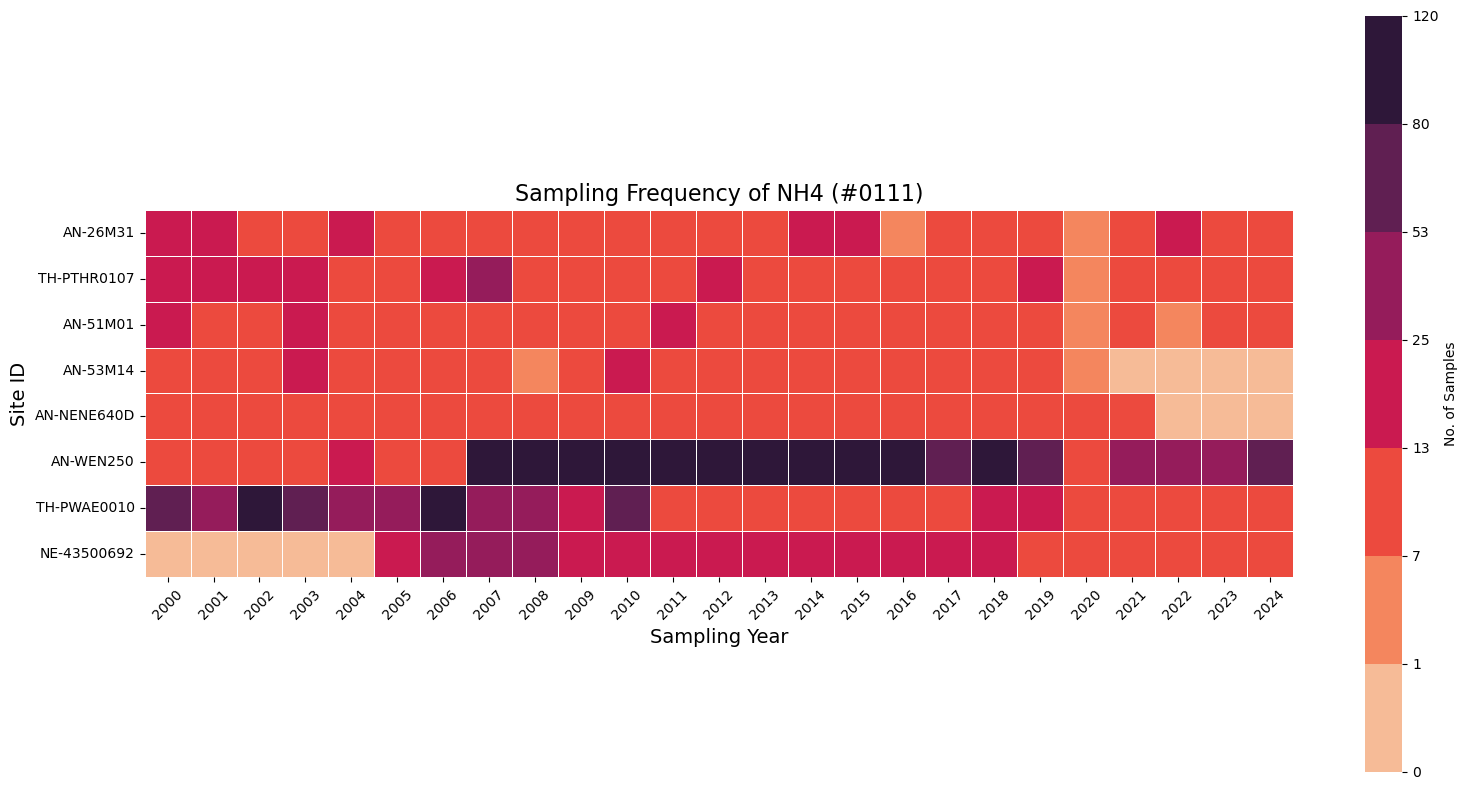

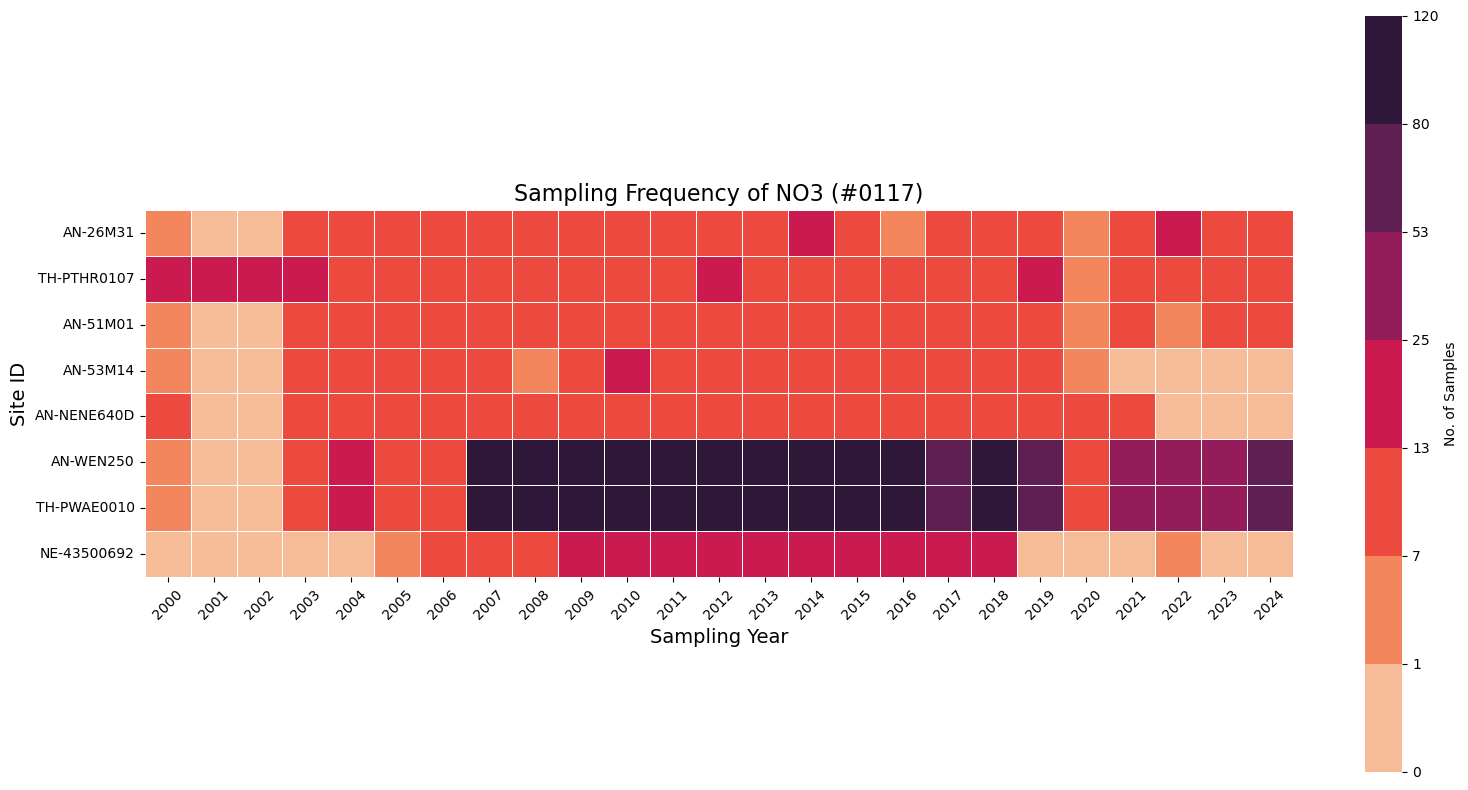

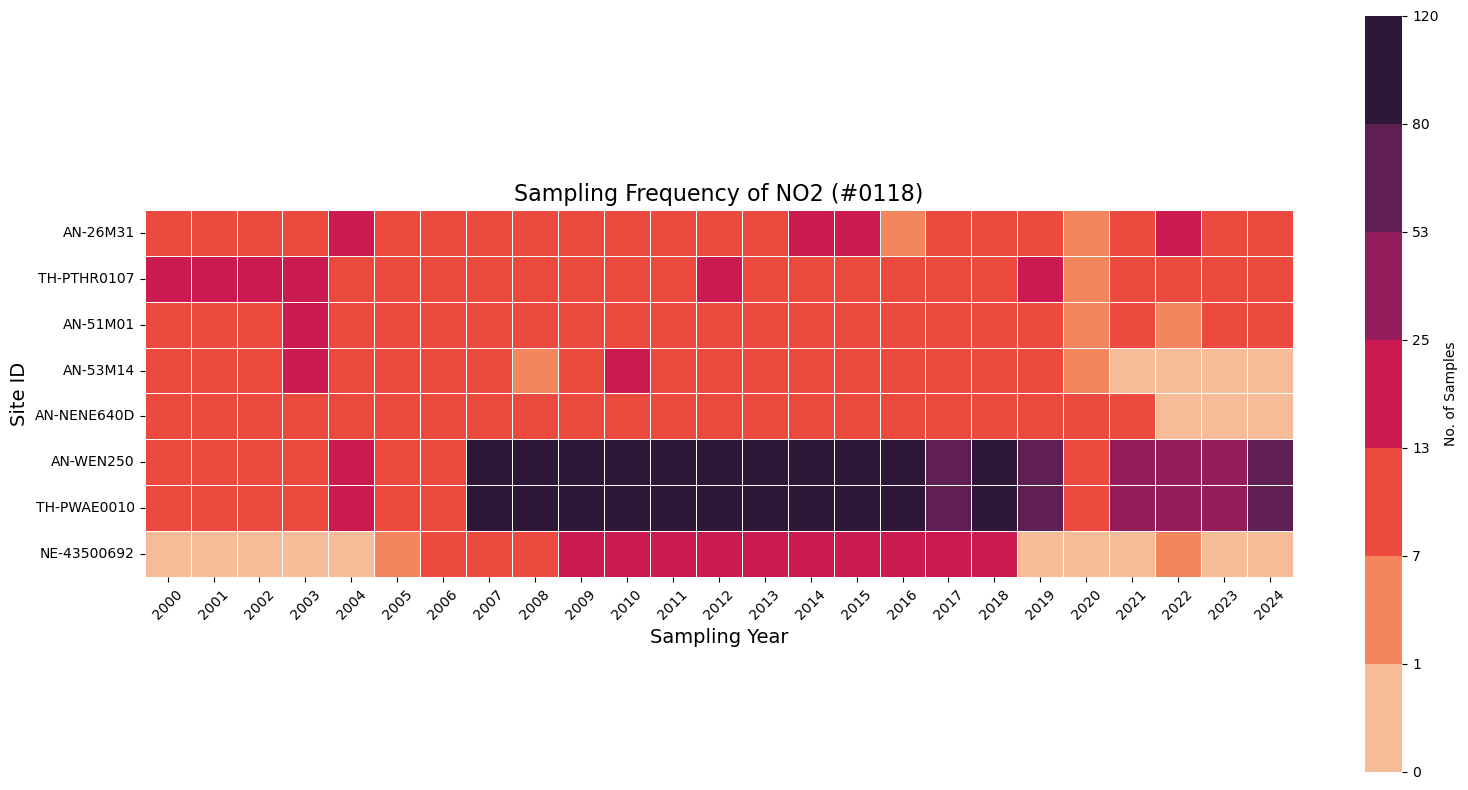

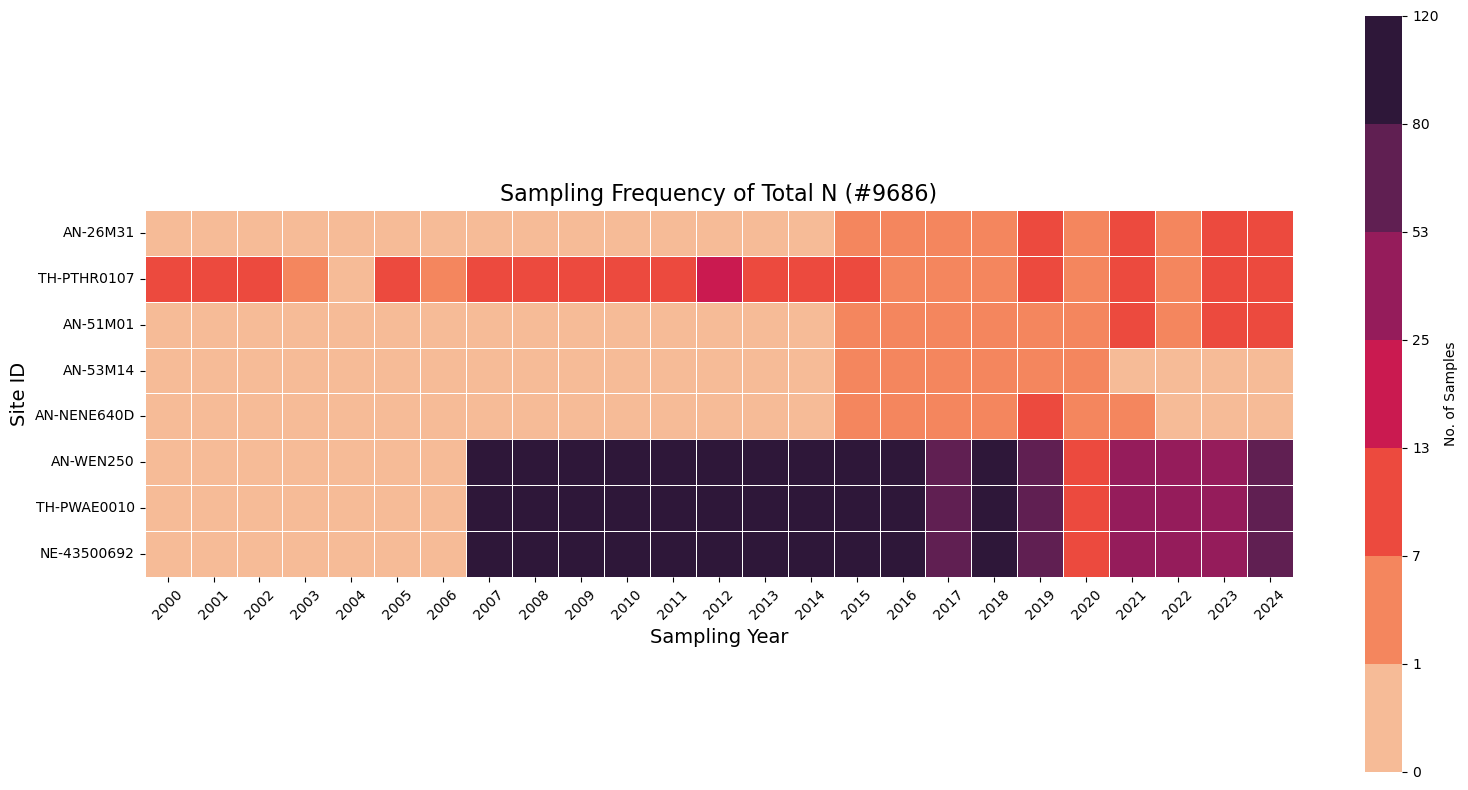

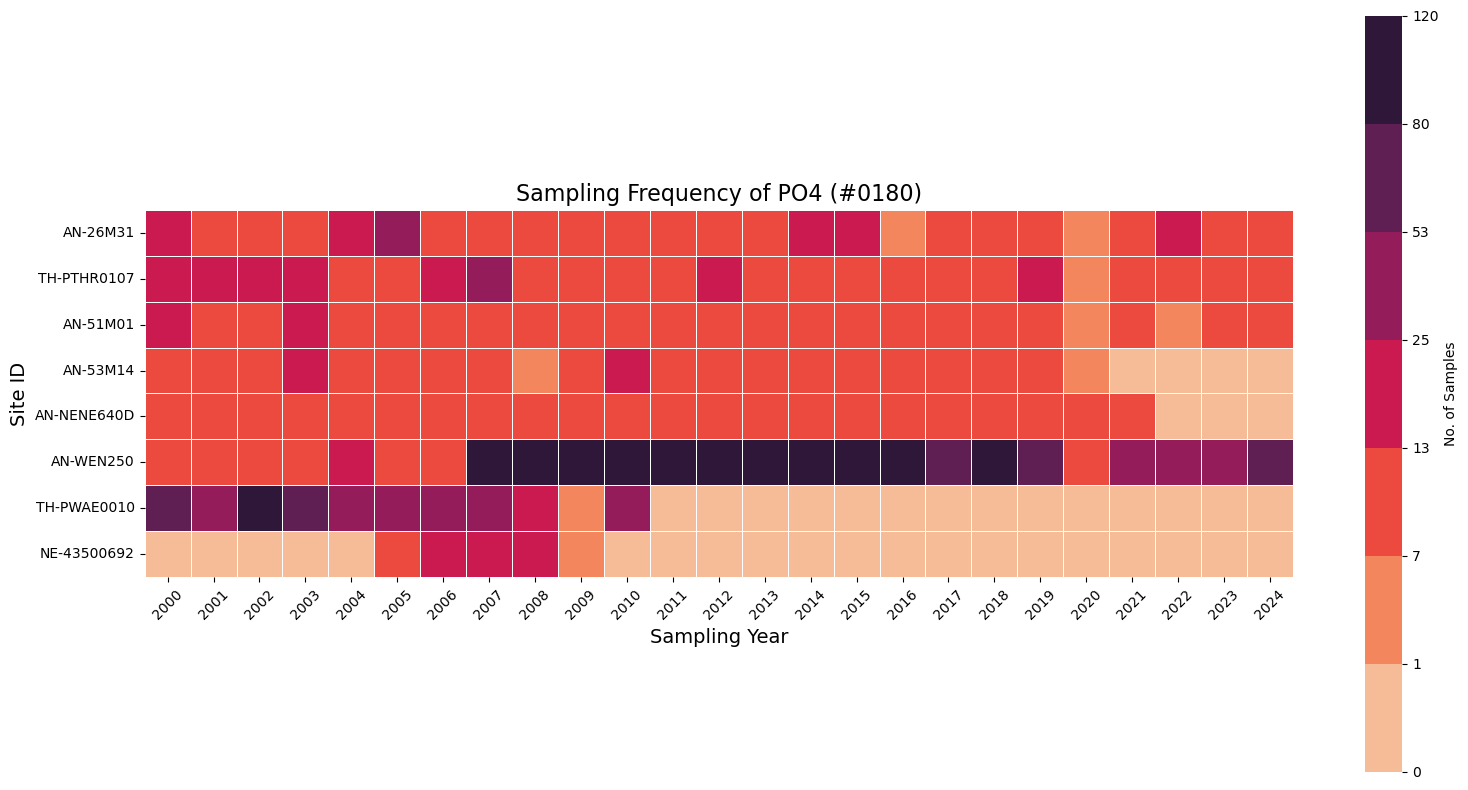

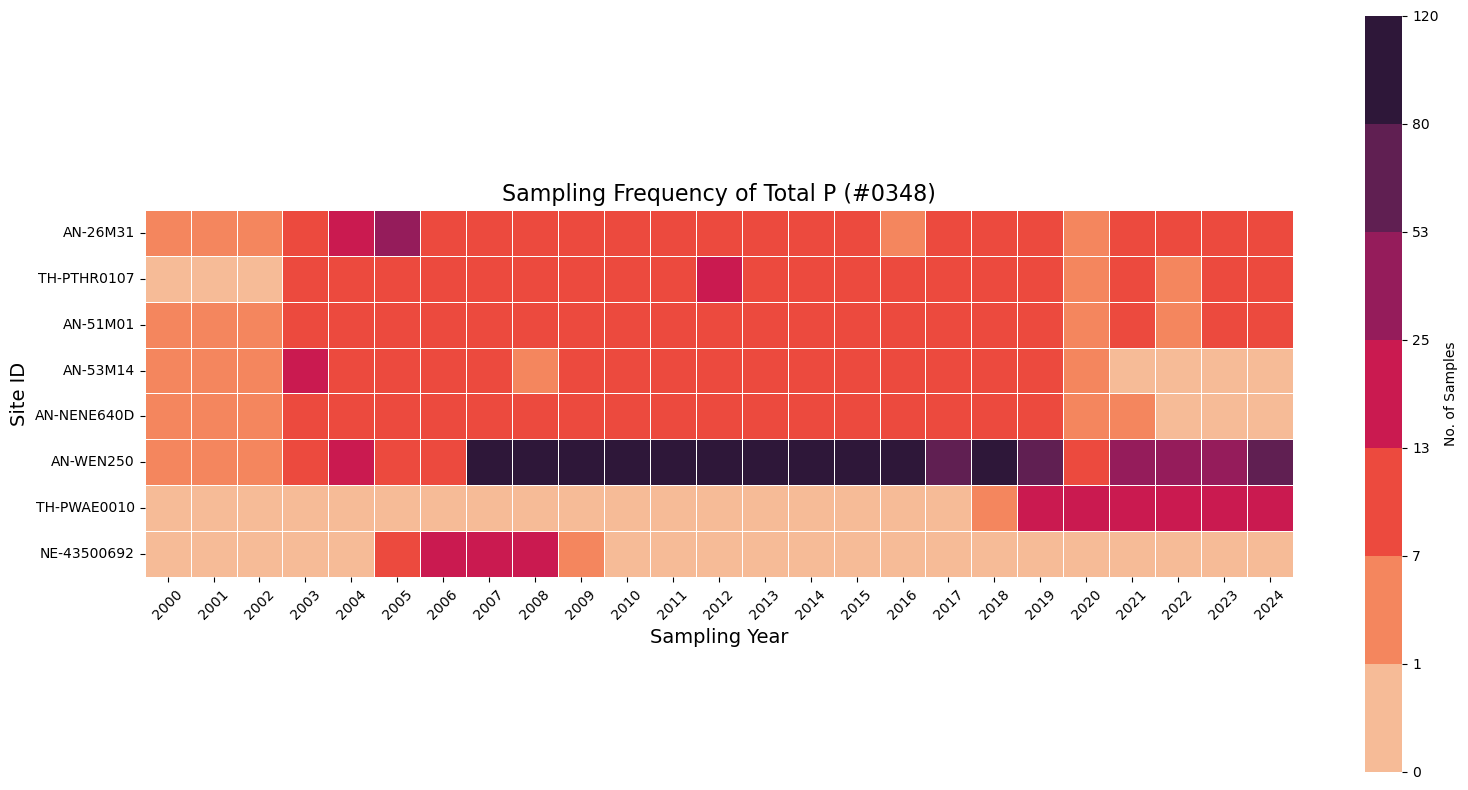

In [37]:
# Ploting sampling frequency heatmaps:

## Define your bin edges
boundaries = [0, 1, 7, 13, 25,  53, 80, 120]
n_bins = len(boundaries) - 1

## Create a discrete color palette with one color per bin
cmap = sns.color_palette("coolwarm_r", n_colors=n_bins)
cmap = ListedColormap(cmap)

## Create a norm that maps each range to a color
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=True)

for dtr in sampling_freq.keys():
    dtr_label = dtrs_labels.get(dtr)
    
    plt.figure(figsize=(16,8))
    
    cmap = sns.color_palette('rocket_r', n_colors = n_bins)
    freq_plot = sns.heatmap(sampling_freq[dtr], cmap= cmap, norm= norm,
                        vmin=0, vmax=300,   
                        cbar=True, cbar_kws={"ticks": boundaries, "label": "No. of Samples"}, square=True, 
                        linecolor='white', linewidths=0.5,
                        xticklabels='auto', yticklabels='auto' 
                        )

    # Axis customisation:
    freq_plot.set_ylabel('Site ID', fontsize = 14)
    freq_plot.set_xlabel("Sampling Year", fontsize = 14)
    freq_plot.set_xticklabels(freq_plot.get_xticklabels(), rotation = 45, fontsize = 10)
    freq_plot.set_yticklabels(freq_plot.get_yticklabels(), fontsize = 10)

    
    
    plt.title(f"Sampling Frequency of {dtr_label}", fontsize = 16)
    plt.tight_layout()

    plt.show()